# Reporte 8   

# Bruno Merino

El articulo busca explicar como la mita, trabajo minero forzoso, afectó a la economía peruana durante 1577 hasta inicios de 1800. Afectando al ingreso económico en los hogares, hábitos de consumo, entre otros.

Entre las fortalezas que se pueden encontrar en el artículo, se puede destacar la inclusión de información relevante de la época como la participación en los mercados, tenencia de tierras y bienes públicos; análisis comparativos en relación a los efectos de la mita en otros lugares de Latinoamérica; el uso de gráficos para explicar la variación de la mita y sus efectos; entre otros.

Por otro lado, entre las debilidades del artículo, considero que, al ser un repaso histórico de los efectos de la mita, se concentra en hechos pasados sin darle una relevancia real o aporte sustancial al sistema económico actual. Otra debilidad seria que no se profundizo en provincias en especifico ni se dio una comparación entre ellas para observas la magnitud real o efectos comunes que se daban debido a la mita.

En cuanto a la contribución del documento, considero que se busca mostrar la influencia de la mita y como esta de alguna manera ha persistido a través de su impacto en la tenencia de la tierra y la provisión de bienes públicos.

Algunos pasos siguientes que se podrían considerar pertinentes serian la comparación histórica de lugares en los que se haya dado la mita a través de documentación recopilada de artículos de la época de las colonias e inicios de la republica.


In [2]:
pip install linearmodels

In [3]:
pip install causalgraphicalmodels

Note: you may need to restart the kernel to use updated packages.


In [50]:
# pip install causalgraphicalmodels
# pip install linearmodels

from causalgraphicalmodels import CausalGraphicalModel
import os
import numpy as np 
import pandas as pd 
import statsmodels.api as sm 
import statsmodels.formula.api as smf 
from itertools import combinations 
import statsmodels.api as sm
import statsmodels.formula.api as smf
import linearmodels.iv.model as lm
from linearmodels.iv import IV2SLS
from statsmodels.iolib.summary2 import summary_col
import seaborn as sns

In [52]:
# load data

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

def read_data(file): 
    return pd.read_stata("https://raw.github.com/scunning1975/mixtape/master/" + file)

card = read_data("card.dta")
card.head()

,id,nearc2,nearc4,educ,age,fatheduc,motheduc,weight,momdad14,sinmom14,...,KWW,IQ,married,libcrd14,exper,lwage,expersq,u_lwage,lwage_hat,u_educ
0,2.0,0.0,0.0,7.0,29.0,NaN,NaN,158413.0,1.0,0.0,...,15.0,NaN,1.0,0.0,16.0,6.306275,256.0,0.198047,6.108228,-3.067539
1,3.0,0.0,0.0,12.0,27.0,8.0,8.0,380166.0,1.0,0.0,...,35.0,93.0,1.0,1.0,9.0,6.175867,81.0,-0.211160,6.387027,-1.727562
2,4.0,0.0,0.0,12.0,34.0,14.0,12.0,367470.0,1.0,0.0,...,42.0,103.0,1.0,1.0,16.0,6.580639,256.0,0.204719,6.375920,1.012975
3,5.0,1.0,1.0,11.0,27.0,11.0,12.0,380166.0,1.0,0.0,...,25.0,88.0,1.0,1.0,10.0,5.521461,100.0,-0.967905,6.489366,-2.253536
4,6.0,1.0,1.0,12.0,34.0,8.0,7.0,367470.0,1.0,0.0,...,34.0,108.0,1.0,0.0,16.0,6.591674,256.0,0.125173,6.466501,1.090437


<h1>1) Para esta primera sección deben darle una leida a The Effect Book principalmente al capitulo de Instrumental Variables.<h1>

* **Explique en qué consiste el supuesto de "Relevance"**

* Se trata de la relación que hay entre X y Z. Cuánto explica Z de X. Entonces debemos estar seguros de que la relación entre Z y X sea fuerte, mientras haya más relación, más podemos estar seguros de la suposición de relevancia. Esta relevancia se puede verificar por el tamaño de la covarianza de (Z, X). Si la Cov(Z, X) es muy pequeño, entonces Z es un instrumento débil para X

* **Explique en qué consiste el supuesto de "Validity"**

* Se trata de la suposición de que el instrumento que explica X, Z, no tienen puertas traseras abiertas propias. Esto quiere decir, que la el instrumento Z, solo debe tener una puerta abierta hacia X, para que así se pueda explicar Y. no importa que haya una variable que regrese a X, el problema es cuando regresa a Z. Por lo que es importante cerrar estas puertas que van de Z a otras variables y que estas expliquen Y de diferentes formas.

<h1>2) Ploteo Histogramas<h1>

* **a) Grafique dos histogramas para la variable años de educación educ para cuando nearc4 == 1, y cuando nearc4 == 0. Compare y describa los patrones que encuentra.**

In [53]:
#Realizamos una copia de la base de datos para no perder la fuente principal

In [54]:
card2=card

In [55]:
#Ajustamos las columnas para las variables a analizar
card3 = card2[['educ','nearc4']]
card3


,educ,nearc4
0,7.0,0.0
1,12.0,0.0
2,12.0,0.0
3,11.0,1.0
4,12.0,1.0
...,...,...
3005,12.0,1.0
3006,13.0,1.0
3007,12.0,1.0
3008,12.0,1.0


In [56]:
#Como sabemos segun la lectura la variable nearc4 se relaciona a la exitencia de colegios 
#"0.0=N_college"
#"1.0=college"

card4 = (card3
 .assign(nearc4_char = np.select(
     [card3["nearc4"].astype(bool), card3["educ"].astype(bool)],
     ["college", "N_college"]
 ))) 
card4

,educ,nearc4,nearc4_char
0,7.0,0.0,N_college
1,12.0,0.0,N_college
2,12.0,0.0,N_college
3,11.0,1.0,college
4,12.0,1.0,college
...,...,...,...
3005,12.0,1.0,college
3006,13.0,1.0,college
3007,12.0,1.0,college
3008,12.0,1.0,college


In [57]:
#agrupamos nuevamente para realizar la realcion de educaion entre la ausencia de colegio y su existencia.
card5 = card4[['educ','nearc4_char']]
card5

,educ,nearc4_char
0,7.0,N_college
1,12.0,N_college
2,12.0,N_college
3,11.0,college
4,12.0,college
...,...,...
3005,12.0,college
3006,13.0,college
3007,12.0,college
3008,12.0,college


<h1>Ploteo Histograma relacion educ y nearc4==0<h1>

In [66]:

Groups = ["N_college"]
DIM = card5[card5['nearc4_char'].isin(Groups)]
DIM

,educ,nearc4_char
0,7.0,N_college
1,12.0,N_college
2,12.0,N_college
295,12.0,N_college
296,12.0,N_college
...,...,...
2992,12.0,N_college
2993,12.0,N_college
2994,14.0,N_college
2995,10.0,N_college


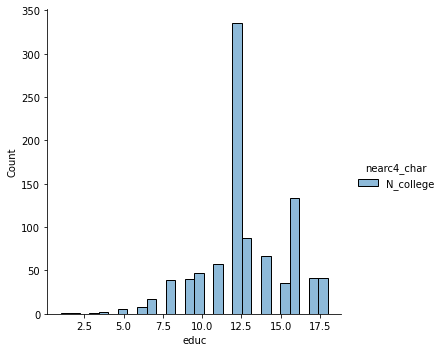

In [76]:
sns.displot(DIM, x="educ", hue= "nearc4_char")

<h1>Ploteo Histograma relacion educ y nearc4==1<h1>

In [60]:

Groups = ["college"]
DIM = card5[card5['nearc4_char'].isin(Groups)]
DIM

,educ,nearc4_char
3,11.0,college
4,12.0,college
5,12.0,college
6,18.0,college
7,14.0,college
...,...,...
3005,12.0,college
3006,13.0,college
3007,12.0,college
3008,12.0,college


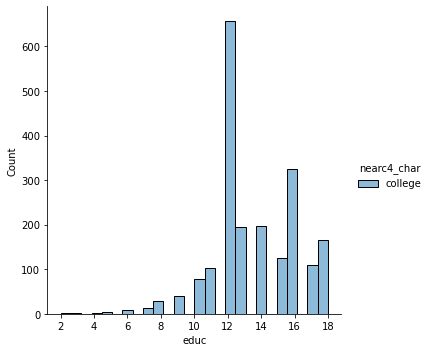

In [61]:
sns.displot(DIM, x="educ", hue= "nearc4_char")

In [62]:
#ploteo de ambas graficas en comparacion

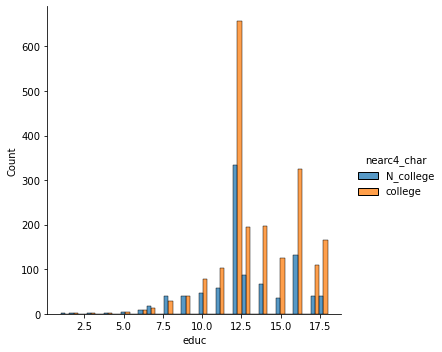

In [63]:
sns.displot(card5, x="educ", hue="nearc4_char", multiple="dodge")

* **interpretación**

*  Siendo nearc4 la presencia de colegios o no, se espera que la presencia de colegios aumente los años de educación en más cantidad de personas. Efectivamente, como se ve en los histogramas, cuando la Dummy nearc4 = 1, la cantidad de personas con más años de educación casi de duplican. Por ejemplo, en las personas con 12 años de educación pasan de 350 a más de 600 personas aproximadamente. Esto se puede ver en la similitud que hay en la forma de los histogramas; sin embargo, en las personas con menos de 10 años de educación, la presencia de un colegio o no se hace menos determinante en comparación con los demás años de educación, pues la cantidad de años de educación es casi la misma con nerac4 =1 o =0.

* **b) Grafique dos histogramas para la variable años del logaritmos de los ingresos lwage para cuando nearc4 == 1, y cuando nearc4 == 0. Compare y describa los patrones que encuentra.**

In [19]:
data2=card

In [22]:
data3 = data2[['lwage','nearc4']]
data3

,lwage,nearc4
0,6.306275,0.0
1,6.175867,0.0
2,6.580639,0.0
3,5.521461,1.0
4,6.591674,1.0
...,...,...
3005,5.814130,1.0
3006,6.175867,1.0
3007,6.214608,1.0
3008,6.569481,1.0


In [24]:
data4 = (data3
 .assign(nearc4_char = np.select(
     [data3["nearc4"].astype(bool),  data3["lwage"].astype(bool)],
     ["college", "N_college"]
 ))) 
data4

,lwage,nearc4,nearc4_char
0,6.306275,0.0,N_college
1,6.175867,0.0,N_college
2,6.580639,0.0,N_college
3,5.521461,1.0,college
4,6.591674,1.0,college
...,...,...,...
3005,5.814130,1.0,college
3006,6.175867,1.0,college
3007,6.214608,1.0,college
3008,6.569481,1.0,college


In [25]:
data5 = data4[['lwage','nearc4_char']]
data5

,lwage,nearc4_char
0,6.306275,N_college
1,6.175867,N_college
2,6.580639,N_college
3,5.521461,college
4,6.591674,college
...,...,...
3005,5.814130,college
3006,6.175867,college
3007,6.214608,college
3008,6.569481,college


<h1>Ploteo Histograma relacion lwage y nearc4==0<h1>

In [26]:

Groups = ["N_college"]
DIM = data5[data5['nearc4_char'].isin(Groups)]
DIM

,lwage,nearc4_char
0,6.306275,N_college
1,6.175867,N_college
2,6.580639,N_college
295,5.899898,N_college
296,6.700731,N_college
...,...,...
2992,6.109248,N_college
2993,5.572154,N_college
2994,6.068426,N_college
2995,5.257495,N_college


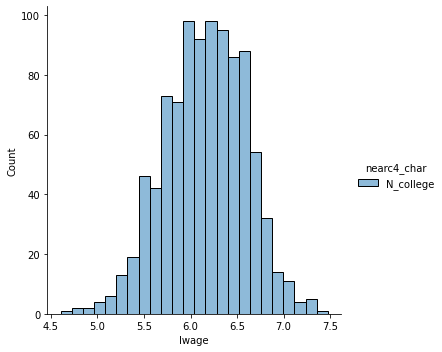

In [27]:
sns.displot(DIM, x="lwage", hue= "nearc4_char")

<h1>Ploteo Histograma relacion lwage y nearc4==1<h1>

In [29]:

Groups = ["college"]
DIM = data5[data5['nearc4_char'].isin(Groups)]
DIM

,lwage,nearc4_char
3,5.521461,college
4,6.591674,college
5,6.214608,college
6,6.336826,college
7,6.410175,college
...,...,...
3005,5.814130,college
3006,6.175867,college
3007,6.214608,college
3008,6.569481,college


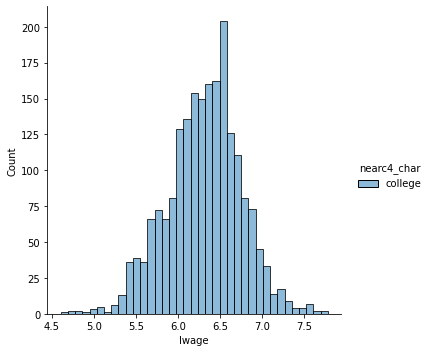

In [30]:
sns.displot(DIM, x="lwage", hue= "nearc4_char")

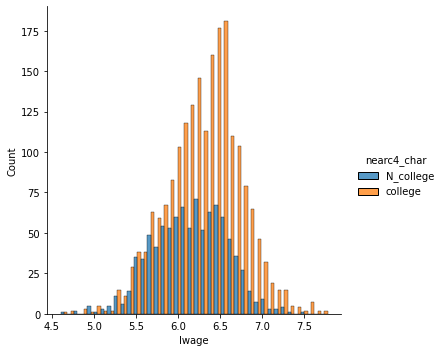

In [32]:
sns.displot(data5, x="lwage", hue="nearc4_char", multiple="dodge")

* **interpretacion**

* Del mismo modo que para el caso de educación, es esperable que la presencia de colegios haga que el logaritmo de los salarios aumente, pues se puede ver en los histogramas que cuando nearc4 = 1, el logaritmo del salario aumenta más del doble respecto a cuando nearc4 = 0. Sin embargo, cuando el logaritmo del salario es menor o igual a 5.5, la influencia de colegios no es tan fuerte, pues incluso llega a ser mayor el logaritmo del salario cuando nearc4 = 0, en algunos casos.

<h1>3) Regresiones<h1>

* **1) una regresion lineal del tipo "lwage ~ educ + exper + black + south + married + smsa", y expliquen los resultados que encuentran.**

In [42]:
#OLS
ols_reg = sm.OLS.from_formula("lwage ~ educ + exper + black + south + married + smsa", 
              data = card).fit()

ols_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  lwage   R-squared:                       0.305
Model:                            OLS   Adj. R-squared:                  0.303
Method:                 Least Squares   F-statistic:                     219.1
Date:                Fri, 11 Nov 2022   Prob (F-statistic):          1.69e-232
Time:                        19:11:52   Log-Likelihood:                -1278.7
No. Observations:                3010   AIC:                             2571.
Df Residuals:                    3003   BIC:                             2613.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.0642      0.064     79.594      0.000       4.939       5.189
educ           0.0711      0.003     20.439      0.000       0.064       0.078
exper          0.0342      0.002     15.459      0.000       0.030       0.039
black         -0.1654      0.018     -9.408      0.000      -0.200      -0.131
south         -0.1325      0.015     -8.855      0.000      -0.162      -0.103
married       -0.0358      0.003    -10.542      0.000      -0.042      -0.029
smsa           0.1751      0.015     11.338      0.000       0.145       0.205
==============================================================================
Omnibus:                       52.534   Durbin-Watson:                   1.853
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               68.142
Skew:                          -0.231   Prob(JB):                     1.60e-15
Kurtosis:                       3.575   Cond. No.                         154.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

* **Interpretacion**

* La regresión del salario versus las variables de: educación, experiencia, Dummy de afro-decendencia, Dummy de región sur, Dummy de casado y smsa. Muestran que el intercepto de la variable endógena "Logaritmo del Salario" es 5.06 unidades logarítmicas. Por otro lado, por cada unidad adicional de cada variable, la variable endógena aumenta menos de 0.2 unidades logarítmicas. Además, si quitamos el logaritmo de la variable endógena se puede observar otro intercepto y otra relación entre las demás variables versus el "Salario"

* **2) Corran una regresion de tipo IV(usando el paquete IV2SLS) donde van a instrumentalizar la variable educ con nearc2 . La regressión debería tener una forma de este tipo "lwage ~ 1 + exper + black + south + married + smsa + [educ ~ nearc4 ]". Compare los resultados encontrados en la regresión de arriba. Cambió el coeficiente relacionado a educ , por qué?**

In [44]:
# There are null values in the dataset, we will fill them with 0
card['married'] = card['married'].fillna(0)

In [45]:
#2SLS
iv_reg = IV2SLS.from_formula("lwage ~  1 + exper + black + south + married + smsa + [educ ~ nearc4]", card).fit()
iv_reg.summary

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                          IV-2SLS Estimation Summary                          
==============================================================================
Dep. Variable:                  lwage   R-squared:                      0.2428
Estimator:                    IV-2SLS   Adj. R-squared:                 0.2413
No. Observations:                3010   F-statistic:                    884.54
Date:                Fri, Nov 11 2022   P-value (F-stat)                0.0000
Time:                        19:13:54   Distribution:                  chi2(6)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept      4.0998     0.8209     4.9942     0.0000      2.4909      5.7088
black         -0.1110     0.0493    -2.2504     0.0244     -0.2076     -0.0143
exper          0.0571     0.0195     2.9262     0.0034      0.0189      0.0953
married       -0.0318     0.0050    -6.3846     0.0000     -0.0415     -0.0220
smsa           0.1448     0.0302     4.8025     0.0000      0.0857      0.2039
south         -0.1128     0.0228    -4.9550     0.0000     -0.1574     -0.0682
educ           0.1279     0.0484     2.6438     0.0082      0.0331      0.2227
==============================================================================

Endogenous: educ
Instruments: nearc4
Robust Covariance (Heteroskedastic)
Debiased: False
"""

In [46]:
#2SLS
iv_reg = IV2SLS.from_formula("lwage ~  1 + exper + black + south + married + smsa + [educ ~ nearc2]", card).fit()
iv_reg.summary

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                          IV-2SLS Estimation Summary                          
==============================================================================
Dep. Variable:                  lwage   R-squared:                     -1.3114
Estimator:                    IV-2SLS   Adj. R-squared:                -1.3160
No. Observations:                3010   F-statistic:                    289.62
Date:                Fri, Nov 11 2022   P-value (F-stat)                0.0000
Time:                        19:13:57   Distribution:                  chi2(6)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept      0.1276     3.1412     0.0406     0.9676     -6.0290      6.2843
black          0.1134     0.1816     0.6244     0.5324     -0.2425      0.4692
exper          0.1515     0.0747     2.0274     0.0426      0.0050      0.2980
married       -0.0151     0.0147    -1.0258     0.3050     -0.0438      0.0137
smsa           0.0201     0.1030     0.1949     0.8455     -0.1819      0.2220
south         -0.0319     0.0692    -0.4603     0.6453     -0.1675      0.1038
educ           0.3618     0.1849     1.9562     0.0504     -0.0007      0.7243
==============================================================================

Endogenous: educ
Instruments: nearc2
Robust Covariance (Heteroskedastic)
Debiased: False
"""

* **interpretacion**

* Comparando ambas regresiones podemos ver que el intercepto ha disminuido considerablemente. Por ejemplo, la Dammy black se hace positiva, lo que quiere decir que si black=1 el intercepto sería mayor, es decir mayor salario.
* Respecto al coeficiente relacionando con la variable educ pasó de 0.1279 a 0.3618: esto quiere decir que, en la segunda regresión, por un año más de educación las unidades logarítmicas del salario aumentan más.
* Sin embargo el P-value no es significativo